In [82]:
from qiskit import IBMQ
IBMQ.load_account()
IBMQ.providers()
providers=IBMQ.get_provider(hub='ibm-q-keio')
providers.backends()

C:\Users\k0e8i\Anaconda3\envs\qiskit\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


[<IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q-keio', group='keio-internal', project='keio-students')>,
 <IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-keio', group='keio-internal', project='keio-students')>,
 <IBMQBackend('ibmq_20_tokyo') from IBMQ(hub='ibm-q-keio', group='keio-internal', project='keio-students')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q-keio', group='keio-internal', project='keio-students')>,
 <IBMQBackend('ibmq_poughkeepsie') from IBMQ(hub='ibm-q-keio', group='keio-internal', project='keio-students')>,
 <IBMQBackend('ibmq_boeblingen') from IBMQ(hub='ibm-q-keio', group='keio-internal', project='keio-students')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q-keio', group='keio-internal', project='keio-students')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q-keio', group='keio-internal', project='keio-students')>,
 <IBMQBackend('ibmq_valencia') from IBMQ(hub='ibm-q-keio', group='keio-internal', project='keio-students')>,
 <IBMQBackend

In [83]:
import math

b_max = math.pi / 5  # upper limit of integral
nbit = 3  # change this value to get discretized result closer to analytical results

analyticResult = (b_max / 2.0 - math.sin(2 * b_max) / 4.0 ) / b_max  # the target integral can be analytically solved
print("Analytical Result:", analyticResult)

ndiv = 2**nbit  #number of discretization 
discretizedResult = 0.0
for i in range(ndiv):
    discretizedResult += math.sin(b_max / ndiv * (i + 0.5))**2
discretizedResult = discretizedResult / ndiv
print("Discretized Result:", discretizedResult)


Analytical Result: 0.12158663567967151
Discretized Result: 0.1211973148745352


In [84]:
def P(qc, qx, nbit):
    """
        Generating uniform probability distribution
            qc: quantum circuit
            qx: quantum register
            nbit: number of qubits
        The inverse of P = P
    """
    qc.h(qx)

def R(qc, qx, qx_measure, nbit, b_max):
    """
        Computing the integral function f()
            qc: quantum circuit
            qx: quantum register
            qx_measure: quantum register for measurement
            nbit: number of qubits
            b_max: upper limit of integral            
    """
    qc.ry(b_max / 2**nbit * 2 * 0.5, qx_measure)
    for i in range(nbit):
        qc.cu3(2**i * b_max / 2**nbit * 2, 0, 0, qx[i], qx_measure[0])

def Rinv(qc, qx, qx_measure, nbit, b_max):
    """
        The inverse of R
            qc: quantum circuit
            qx: quantum register
            qx_measure : quantum register for measurement
            nbit: number of qubits
            b_max: upper limit of integral
    """
    for i in range(nbit)[::-1]:
        qc.cu3(-2**i * b_max / 2**nbit * 2, 0, 0, qx[i], qx_measure[0])
    qc.ry(-b_max / 2**nbit * 2 * 0.5, qx_measure)

In [85]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute
from qiskit import IBMQ
from qiskit import Aer
from scipy import optimize
import sys, time
import mpmath as mp
import numpy as np
import matplotlib.pyplot as plt

In [86]:
# Functions to construct circuits for Grover operators
def multi_control_NOT(qc, qx, qx_measure, qx_ancilla, nbit, b_max):
    """
        Computing multi controlled NOT gate
            qc: quantum circuit
            qx: quantum register
            qx_measure: quantum register for measurement
            qx_ancilla: temporal quantum register for decomposing multi controlled NOT gate
            nbit: number of qubits
            b_max: upper limit of integral
    """

    if nbit == 1:
        qc.cz(qx[0], qx_measure[0])
    elif nbit == 2:
        qc.h(qx_measure[0])
        qc.ccx(qx[0], qx[1], qx_measure[0])
        qc.h(qx_measure[0])
    elif nbit > 2.0:
        qc.ccx(qx[0], qx[1], qx_ancilla[0])
        for i in range(nbit - 3):
            qc.ccx(qx[i + 2], qx_ancilla[i], qx_ancilla[i + 1])
        qc.h(qx_measure[0])
        qc.ccx(qx[nbit - 1], qx_ancilla[nbit - 3], qx_measure[0])
        qc.h(qx_measure[0])
        for i in range(nbit - 3)[::-1]:
            qc.ccx(qx[i + 2], qx_ancilla[i], qx_ancilla[i + 1])
        qc.ccx(qx[0], qx[1], qx_ancilla[0])


def reflect(qc, qx, qx_measure, qx_ancilla, nbit, b_max):
    """
        Computing reflection operator (I - 2|0><0|)
            qc: quantum circuit
            qx: quantum register
            qx_measure: quantum register for measurement
            qx_ancilla: temporal quantum register for decomposing multi controlled NOT gate
            nbit: number of qubits
            b_max: upper limit of integral
    """
    for i in range(nbit):
        qc.x(qx[i])
    qc.x(qx_measure[0])
    qc.barrier()    #format the circuits visualization
    multi_control_NOT(qc, qx, qx_measure, qx_ancilla, nbit, b_max)
    qc.barrier()    #format the circuits visualization
    qc.x(qx_measure[0])
    for i in range(nbit):
        qc.x(qx[i])


# This is to implement Grover Operator
def Q_grover(qc, qx, qx_measure, qx_ancilla, nbit, b_max):
    """
        The Grover operator: R P (I - 2|0><0|) P^+ R^+ U_psi_0 
            qc: quantum circuit
            qx: quantum register
            qx_measure: quantum register for measurement
            qx_ancilla: temporal quantum register for decomposing multi controlled NOT gate
            nbit: number of qubits
            b_max: upper limit of integral
    """
    qc.z(qx_measure[0])
    Rinv(qc, qx, qx_measure, nbit, b_max)
    qc.barrier()    #format the circuits visualization
    P(qc, qx, nbit)
    reflect(qc, qx, qx_measure, qx_ancilla, nbit, b_max)
    P(qc, qx, nbit)
    qc.barrier()    #format the circuits visualization
    R(qc, qx, qx_measure, nbit, b_max)

In [87]:
def create_grover_circuit(numebr_grover_list, nbit, b_max):
    """
        To generate quantum circuits running Grover operators with number of iterations in number_grover_list
            numebr_grover_list: list of number of Grover operators
            nbit: number of qubits (2**nbit = ndiv is the number of discretization in the Monte Carlo integration)
            b_max: upper limit of integral
        Return:
            qc_list: quantum circuits with Grover operators as in number_grover_list
    """
    qc_list = []
    for igrover in range(len(numebr_grover_list)):
        qx = QuantumRegister(nbit)
        qx_measure = QuantumRegister(1)
        cr = ClassicalRegister(1)
        if (nbit > 2):
            qx_ancilla = QuantumRegister(nbit - 2)
            qc = QuantumCircuit(qx, qx_ancilla, qx_measure, cr)
        else:
            qx_ancilla = 0
            qc = QuantumCircuit(qx, qx_measure, cr)
        P(qc, qx, nbit)
        R(qc, qx, qx_measure, nbit, b_max)
        for ikAA in range(numebr_grover_list[igrover]):
            Q_grover(qc, qx, qx_measure, qx_ancilla, nbit, b_max)
        qc.measure(qx_measure[0], cr[0])
        qc_list.append(qc)
    return qc_list

C:\Users\k0e8i\Anaconda3\envs\qiskit\lib\site-packages\qiskit\visualization\matplotlib.py:143: DeprecationWarning: style option/s (usepiformat, compress) is/are not supported
  self._style.set_style(style)


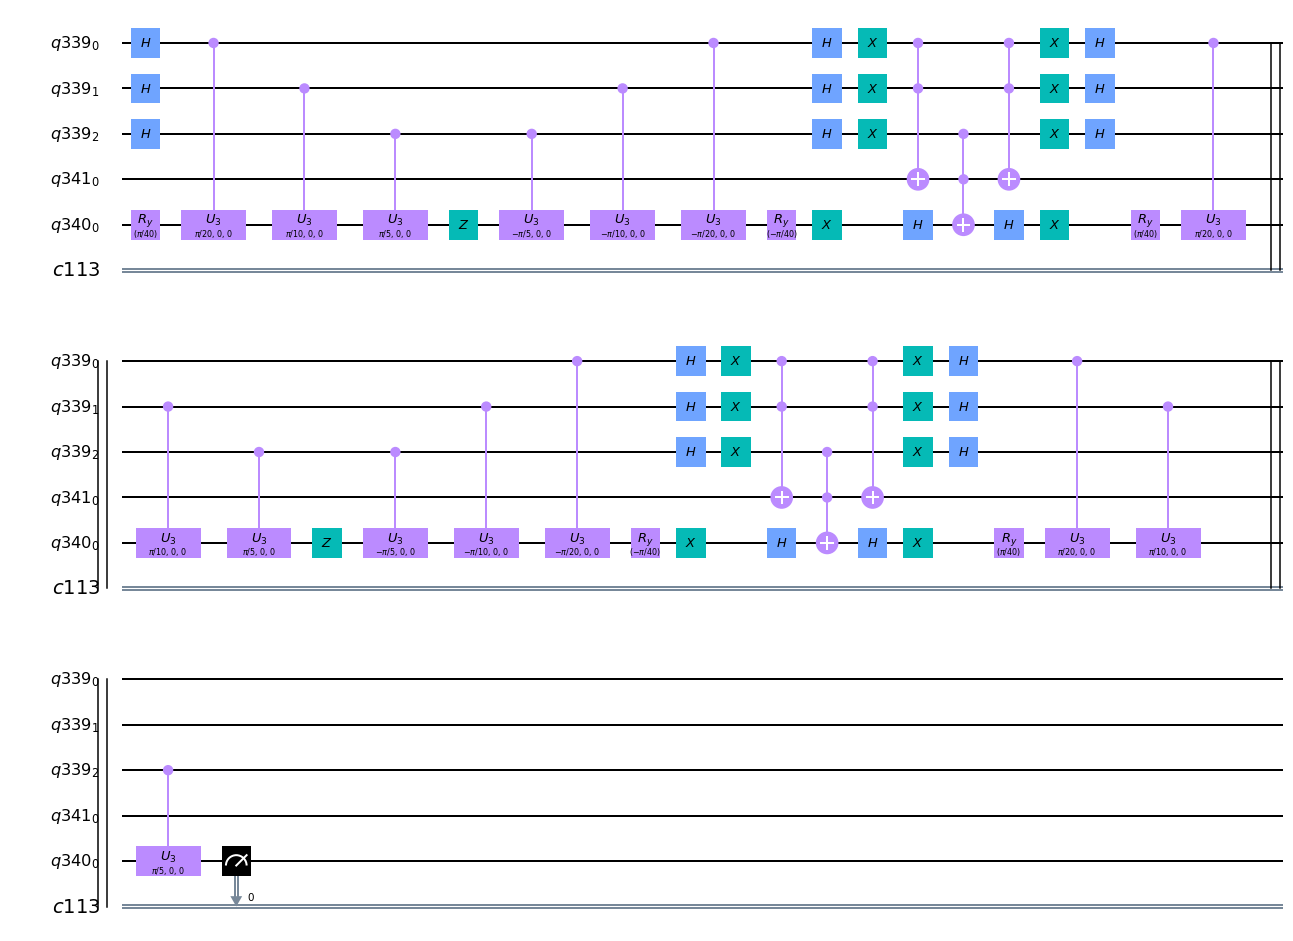

In [88]:
qc_list = create_grover_circuit([2], nbit, b_max)
my_style = {'usepiformat': True, 'cregbundle': True,'compress': True }
qc_list[0].draw(output="mpl", style=my_style, plot_barriers=False )

In [89]:
def run_grover(qc_list, number_grover_list, shots_list, backend):
    """
        Run the quantum circuits returned by create_grover_circuit()
            qc_list: list of quantum circuits
            numebr_grover_list: list of number of Grover operators
            shots_list:  list of number of shots
            backend: name of backends
        
        Return:
            hit_list: list of count of obserbving "1" for qc_list
    """
    hit_list = []
    for k in range(len(number_grover_list)):
        job = execute(qc_list[k], backend=backend, shots=shots_list[k])
        lapse = 0
        interval = 0.00001
        time.sleep(interval)
        while job.status().name != 'DONE':
            time.sleep(interval)
            lapse += 1
        counts = job.result().get_counts(qc_list[k]).get("1", 0)
        hit_list.append(counts)
    return hit_list

In [90]:
def calculate_theta(hit_list, number_grover_list, shots_list):
    """
        calculate optimal theta values
            hit_list: list of count of obserbving "1" for qc_list
            numebr_grover_list: list of number of Grover operators        
            shots_list: list of number of shots

        Return:
            thetaCandidate_list: list of optimal theta
    """

    small = 1.e-15  # small valued parameter to avoid zero division
    confidenceLevel = 5  # confidence level to determine the search range

    thetaCandidate_list = []
    rangeMin = 0.0 + small
    rangeMax = 1.0 - small
    for igrover in range(len(number_grover_list)):

        def loglikelihood(p):
            ret = np.zeros_like(p)
            theta = np.arcsin(np.sqrt(p))
            for n in range(igrover + 1):
                ihit = hit_list[n]
                arg = (2 * number_grover_list[n] + 1) * theta
                ret = ret + 2 * ihit * np.log(np.abs(np.sin(arg))) + 2 * (
                    shots_list[n] - ihit) * np.log(np.abs(np.cos(arg)))
            return -ret

        searchRange = (rangeMin, rangeMax)
        searchResult = optimize.brute(loglikelihood, [searchRange])
        pCandidate = searchResult[0]
        thetaCandidate_list.append(np.arcsin(np.sqrt(pCandidate)))
        perror = CalcErrorCramérRao(igrover, shots_list, pCandidate, number_grover_list)
        rangeMax = min(pCandidate+confidenceLevel*perror,1.0 - small)
        rangeMin = max(pCandidate-confidenceLevel*perror,0.0 + small)
    return thetaCandidate_list

In [92]:
#setting the number of shots and Grover operators.

shots_list = [100]*20# list of number of shots
number_grover_list = [(iii)*8 for iii in range(20)]  # list of number of Grover operators
if len(shots_list) != len(number_grover_list):
    raise Exception(
        'The length of shots_list should be equal to the length of number_grover_list.'
    )

backend = providers.get_backend('ibmq_poughkeepsie')
print(shots_list)
print(number_grover_list)

[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
[0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152]


In [93]:
def CalcErrorCramérRao(M, shot_list, p0, number_grover_list):
    """
        calculate Cramér-Rao lower bound
            M: upper limit of the sum in Fisher information 
            shots_list:  list of number of shots
            p0: the true parameter value to be estimated
            numebr_grover_list: list of number of Grover operators        

        Return:
            square root of Cramér-Rao lower bound:  lower bound on the standard deviation of unbiased estimators
    """
    FisherInfo = 0
    for k in range(M + 1):
        Nk = shot_list[k]
        mk = number_grover_list[k]
        FisherInfo += Nk / (p0 * (1 - p0)) * (2 * mk + 1)**2
    return np.sqrt(1 / FisherInfo)


def CalcNumberOracleCalls(M, shot_list, number_grover_list):
    """
        calculate the total number of oracle calls
            M: upper limit of the sum in Fisher information 
            shots_list:  list of number of shots
            numebr_grover_list: list of number of Grover operators        

        Return:
            Norac: the total number of oracle calls
    """
    Norac = 0
    for k in range(M + 1):
        Nk = shots_list[k]
        mk = number_grover_list[k]
        Norac += Nk * (2 * mk + 1)
    return Norac

In [ ]:
qc_list = create_grover_circuit(number_grover_list, nbit,
                                b_max)  # list of Grover circuits
hit_list = run_grover(qc_list, number_grover_list, shots_list,
                      backend)  # list of number of grover operators
thetaCandidate_list = calculate_theta(
    hit_list, number_grover_list, shots_list)  # list of estimated theta values
print(hit_list)
plt.scatter(number_grover_list,hit_list)
plt.show()

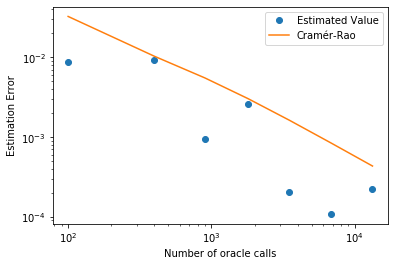

In [54]:

error_list = np.abs(np.sin(thetaCandidate_list)**2 - discretizedResult)  # list of estimation errors
OracleCall_list = []  # list of number of oracle calls
ErrorCramérRao_list = []  # list of Cramér-Rao lower bound
for i in range(len(number_grover_list)):
    OracleCall_list.append(
        CalcNumberOracleCalls(i, shots_list, number_grover_list))
    ErrorCramérRao_list.append(
        CalcErrorCramérRao(i, shots_list, discretizedResult, number_grover_list))

p1 = plt.plot(OracleCall_list, error_list, 'o')
p2 = plt.plot( OracleCall_list, ErrorCramérRao_list)
plt.xscale('log')
plt.xlabel("Number of oracle calls")
plt.yscale('log')
plt.ylabel("Estimation Error")
plt.legend((p1[0], p2[0]), ("Estimated Value", "Cramér-Rao"))
plt.show()